# 250 Examples MNIST

In this example, we only use two dimensions to model all 10 MNIST digits, using 25 examples per digit class. We model them all as generated by a single distribution, so no class-conditional modelling.

In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.figsize'] = (12.0, 4.0)
matplotlib.rcParams['font.size'] = 7

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
import logging
import importlib
importlib.reload(logging) # see https://stackoverflow.com/a/21475297/1469195
log = logging.getLogger()
log.setLevel('DEBUG')
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)
seaborn.set_palette('colorblind')
import os
# add the repo itself
os.sys.path.insert(0, '/home/schirrmr/code/explaining/reversible//')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import copy
import math

import itertools
from reversible.plot import create_bw_image

### Load MNIST

In [3]:
import pickle
import gzip
## from  http://deeplearning.net/data/mnist/mnist.pkl.gz
train, val, test = pickle.load(gzip.open('/data/schirrmr/schirrmr/mnist/mnist.pkl.gz'), encoding='bytes')

X_train, y_train = train
X_val, y_val = val

X_train_topo = X_train.reshape(X_train.shape[0], 1, 28,28)
X_val_topo = X_val.reshape(X_val.shape[0], 1, 28,28)
from numpy.random import RandomState



#### 25 examples per class

In [4]:
from reversible.util import np_to_var, var_to_np
xs = []
ys = []
for i_class in range(10):
    xs.append(X_train_topo[y_train==i_class][:25])
    ys.append(y_train[y_train==i_class][:25])
    
x = np.concatenate(xs)
y = np.concatenate(ys)

inputs = np_to_var(x, dtype=np.float32).cuda()
# we put all digits into one class now
targets = np_to_var(np.ones((len(x), 1)), dtype=np.float32).cuda()

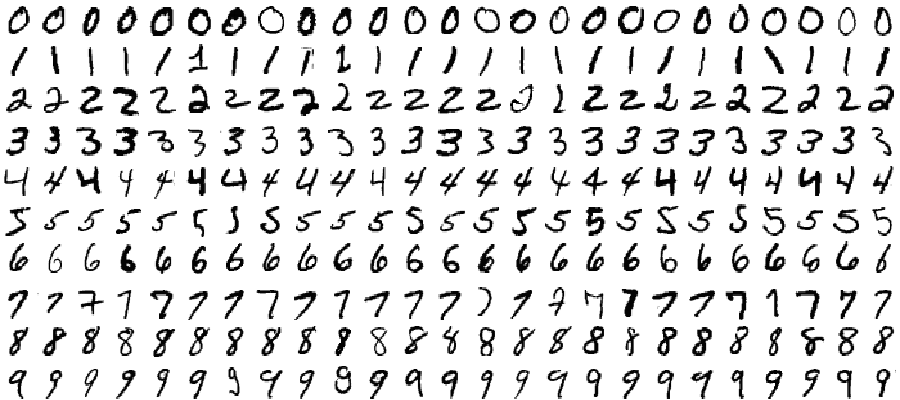

In [7]:
image_grid = np.zeros((10,25,28,28))
for i_row in range(image_grid.shape[0]):
    for i_col in range(image_grid.shape[1]):
        image_grid[i_row, i_col] = var_to_np(inputs[i_row * image_grid.shape[1] + i_col])
im = create_bw_image(image_grid).resize((9*100,4*100))
display(im)

### Reversible Net creation

In [5]:
from reversible.revnet import ReversibleBlockOld
import torch.nn as nn

def rev_block(n_chans, n_intermediate_chans, kernel_size=3):
    c = n_chans // 2
    n_i_c = n_intermediate_chans
    assert kernel_size % 2 == 1
    padding = kernel_size // 2
    return ReversibleBlockOld(
        nn.Sequential(
            nn.Conv2d(c, n_i_c, (kernel_size, kernel_size), padding=padding),
             nn.ReLU(),
             nn.Conv2d(n_i_c, c, (kernel_size,kernel_size), padding=padding)),
        nn.Sequential(
            nn.Conv2d(c, n_i_c, (kernel_size,kernel_size), padding=padding),
            nn.ReLU(),
            nn.Conv2d(n_i_c, c, (kernel_size,kernel_size), padding=padding)))

In [6]:
from reversible.revnet import SubsampleSplitter, ViewAs
from reversible.util import set_random_seeds
from reversible.revnet import init_model_params
from torch.nn import ConstantPad2d
import torch as th
set_random_seeds(3049, True)
feature_model = th.nn.Sequential(
    ConstantPad2d((2,2,2,2), 0),
    SubsampleSplitter(stride=2,checkerboard=True, chunk_chans_first=False),
    rev_block(4,25),
    rev_block(4,25),
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(16,50),
    rev_block(16,50),
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(64,100),
    rev_block(64,100),
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(256,200),
    rev_block(256,200),
    SubsampleSplitter(stride=2,checkerboard=True),
    rev_block(1024,200, kernel_size=1),
    ViewAs((-1,1024,1,1),(-1,1024)),)

feature_model = feature_model.cuda()
from reversible.training import hard_init_std_mean
n_dims = 1024
n_clusters = 1
# will be initialized properly later
means_per_cluster = [th.autograd.Variable(th.zeros(n_dims).cuda(), requires_grad=True)
                     for _ in range(n_clusters)]
stds_per_cluster = [th.autograd.Variable(th.ones(n_dims).cuda(), requires_grad=True)
                    for _ in range(n_clusters)]

# set only two dimensions to 1
means_per_cluster[0].data[:] = 0
stds_per_cluster[0].data[:] = 0
stds_per_cluster[0].data[465] = 1
stds_per_cluster[0].data[700] = 1

from copy import deepcopy
optimizer = th.optim.Adam([
    {'params': [p for p in feature_model.parameters() if p.requires_grad],
    'lr': 0.001,},],)

### Adversary Creation

In [8]:
from reversible.spectral_norm import SpectralNorm
from torch import nn
class ConcatReLU(nn.Module):
    def __init__(self):
        super(ConcatReLU, self).__init__()

    def forward(self, x):
        return th.cat((nn.functional.relu(x), -nn.functional.relu(-x)), dim=1)

def create_adv_2_layer(dim, intermediate_dim, snorm):
    if snorm is None:
        model = nn.Sequential(
            nn.Linear(dim, intermediate_dim),
            ConcatReLU(),
            nn.Linear(intermediate_dim*2, intermediate_dim*2),
            nn.ReLU(),
            nn.Linear(intermediate_dim*2, 1))
    else:
        model = nn.Sequential(
            SpectralNorm(nn.Linear(dim, intermediate_dim), power_iterations=1, to_norm=snorm),
            ConcatReLU(),
            SpectralNorm(nn.Linear(intermediate_dim*2, intermediate_dim*2), power_iterations=1, to_norm=snorm),
            nn.ReLU(),
            SpectralNorm(nn.Linear(intermediate_dim*2, 1), power_iterations=1, to_norm=snorm))

    model = model.cuda()
    return model

In [9]:
adversary = create_adv_2_layer(2, 200, snorm=1)

In [10]:
optim_adv = th.optim.Adam([{
    'params': [p for p in adversary.parameters() if p.requires_grad],
    'lr:': 0.0004, 'weight_decay': 0.00}],
                         betas=(0,0.9))

In [11]:
optimizer = th.optim.Adam(
                          [
    {'params': list(feature_model.parameters()),
    'lr': 0.0001,
    'weight_decay': 0},], betas=(0,0.9))

### Training functions

In [13]:
import time
from reversible.gaussian import get_gauss_samples
from reversible.revnet import invert 

def take_only_large_stds(l_out, std, n_wanted_stds):
    i_stds = th.sort(std)[1][-n_wanted_stds:]
    l_out = l_out.index_select(index=i_stds, dim=1)
    return l_out

def train_critic_on_batch(b_X):
    start_time = time.time()
    result = {}
    i_class = 0
    mean = means_per_cluster[i_class]
    std = stds_per_cluster[i_class] * stds_per_cluster[i_class]
    outs_real = feature_model(b_X)
    samples = get_gauss_samples(750, mean, std)
    # first sample_loss
    score_real = adversary(take_only_large_stds(outs_real,std, n_wanted_stds=2))
    score_fake = adversary(take_only_large_stds(samples, std, n_wanted_stds=2))
    d_loss = nn.functional.relu(1.0 - score_real).mean() + nn.functional.relu(
                1.0 + score_fake).mean()
    optim_adv.zero_grad()
    d_loss.backward()
    all_params = [p for group in optim_adv.param_groups for p in group['params']]
    grad_norm = th.nn.utils.clip_grad_norm(all_params, 1000, 2)
    optim_adv.step()
    runtime = time.time() - start_time
    result['d_loss'] = var_to_np(d_loss)[0]
    result['runtime_d'] = runtime
    result['grad_norm_D'] = grad_norm
    return result

def train_gen_on_batch(b_X, only_clamp):
    start_time = time.time()
    result = {}
    i_class = 0
    mean = means_per_cluster[i_class]
    std = stds_per_cluster[i_class] * stds_per_cluster[i_class]
    outs_real = feature_model(b_X)
    if only_clamp == False:
        samples = get_gauss_samples(750, mean, std)
        # sample loss
        score_real = adversary(take_only_large_stds(outs_real, std, n_wanted_stds=2))
        g_loss_samples = th.mean(score_real)
    
    min_vals = (mean - 20 * std).unsqueeze(0)
    max_vals = (mean + 20 * std).unsqueeze(0)
    outs_clamped = th.min(th.max(outs_real,min_vals.detach()), max_vals.detach())
    
    out_clamp_loss = th.mean((outs_clamped - outs_real) ** 2) * 10
    inverted_clamped = invert(feature_model, outs_clamped)
    in_clamp_loss = th.mean(th.abs(b_X - inverted_clamped)) * 10
    if only_clamp != False:
        g_loss_samples = th.autograd.Variable(th.zeros(1).cuda())
        runtime_d= 0
    if only_clamp == 'in':
        out_clamp_loss = th.autograd.Variable(th.zeros(1).cuda())
    g_loss = in_clamp_loss + out_clamp_loss + g_loss_samples
    
    optimizer.zero_grad()
    g_loss.backward()
    all_params = [p for group in optimizer.param_groups for p in group['params']]
    grad_norm = th.nn.utils.clip_grad_norm(all_params, 5, 2)
    optimizer.step()
    runtime = time.time() - start_time
    result['g_loss'] = var_to_np(g_loss)[0]
    result['g_loss_samples'] = var_to_np(g_loss_samples)[0]
    result['in_loss'] = var_to_np(in_clamp_loss)[0]
    result['out_loss'] = var_to_np(out_clamp_loss)[0]
    result['runtime_g'] = runtime
    result['grad_norm_g'] = grad_norm
    return result
from reversible.sliced import sliced_from_samples
# let's add sliced metric
def compute_sliced_dist_on_outputs():
    # Sliced distance outputs/gaussian samples
    # normalized by sliced distance of two gaussian samples
    i_class = 0
    mean = means_per_cluster[i_class]
    std = stds_per_cluster[i_class] * stds_per_cluster[i_class]
    reduced_outs = take_only_large_stds(feature_model(inputs.cuda()), stds_per_cluster[0] * stds_per_cluster[0],
                                        n_wanted_stds=2)
    reduced_mean = take_only_large_stds(mean.unsqueeze(0),std,n_wanted_stds=2).squeeze(0)
    reduced_std = take_only_large_stds(std.unsqueeze(0),std,n_wanted_stds=2).squeeze(0)

    gauss_samples = get_gauss_samples(len(reduced_outs), reduced_mean, reduced_std)


    sliced_dist = sliced_from_samples(reduced_outs,
                        gauss_samples, n_dirs=2, adv_dirs=None, orthogonalize=True,
                        dist='sqw2')

    gauss_samples_2 = get_gauss_samples(len(reduced_outs), reduced_mean, reduced_std)
    sliced_ref = sliced_from_samples(gauss_samples_2,
                        gauss_samples, n_dirs=2, adv_dirs=None, orthogonalize=True,
                        dist='sqw2')
    sliced_rel = sliced_dist / sliced_ref
    return sliced_rel

## Training loop

In [14]:
import pandas as pd
epochs_dataframe = pd.DataFrame()

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
0,2.004763,3.204816,-0.001641,0.729875,14.844487,2.100487,1.10597,1.838864,0.055285,1.438007,38.160881


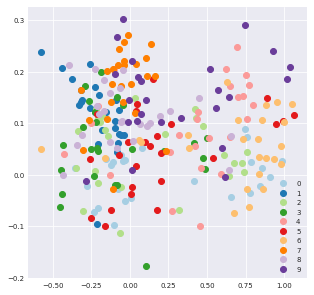

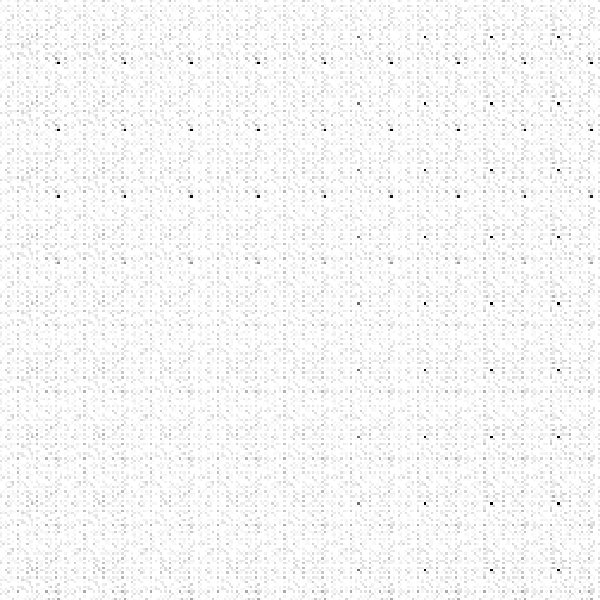

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
50,2.060919,1.950645,0.313915,0.194797,6.624079,1.327382,0.309348,0.182636,0.045717,0.096461,7.719339


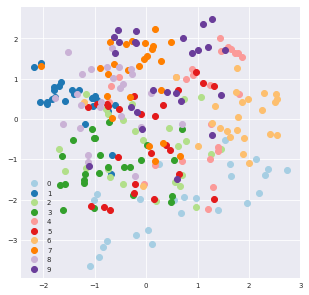

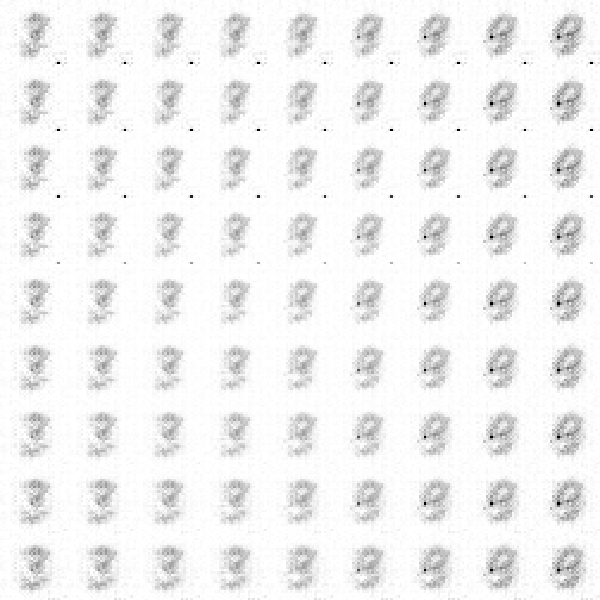

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
100,1.987334,1.846243,0.411121,0.081211,6.553954,1.249226,0.185896,0.19091,0.045684,0.096283,0.67953


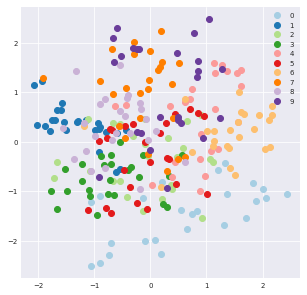

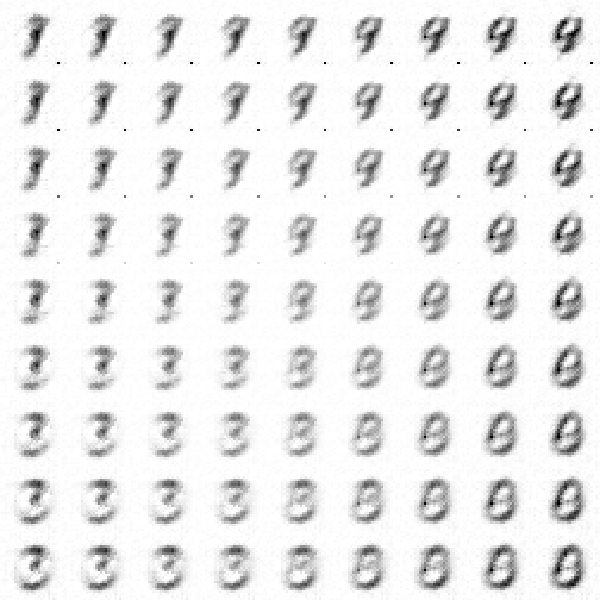

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
150,1.992499,1.982386,0.666035,0.038193,6.064283,1.168027,0.148324,0.212147,0.045424,0.095944,0.786513


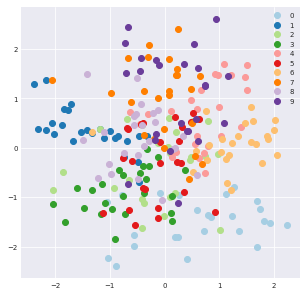

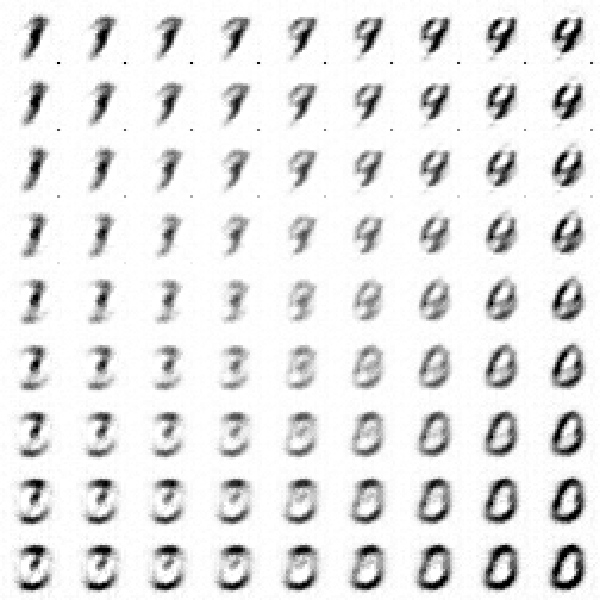

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
200,1.996596,1.912856,0.692947,0.07155,6.832984,1.091639,0.12827,0.185421,0.045427,0.096294,0.803026


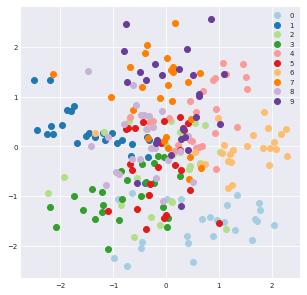

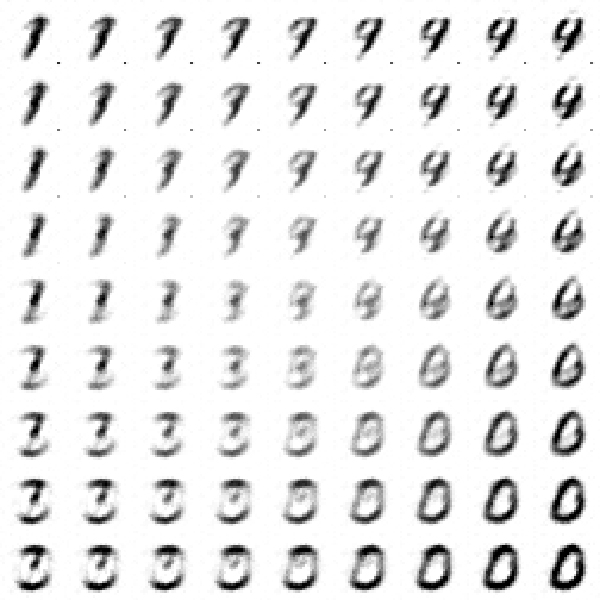

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
250,1.995041,2.00148,0.834754,0.050842,6.563529,1.051071,0.115654,0.192711,0.045505,0.096954,1.640122


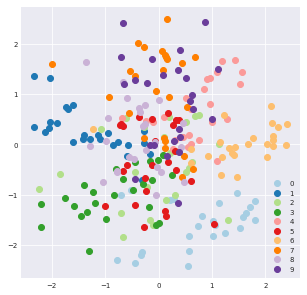

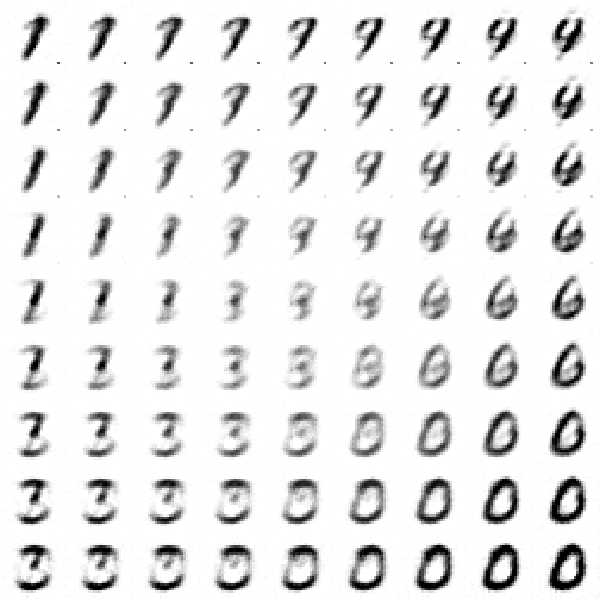

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
300,1.994525,1.73455,0.577177,0.046293,4.045298,1.050011,0.107361,0.198084,0.046195,0.09679,1.066038


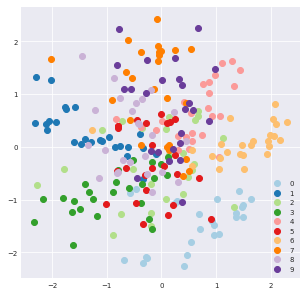

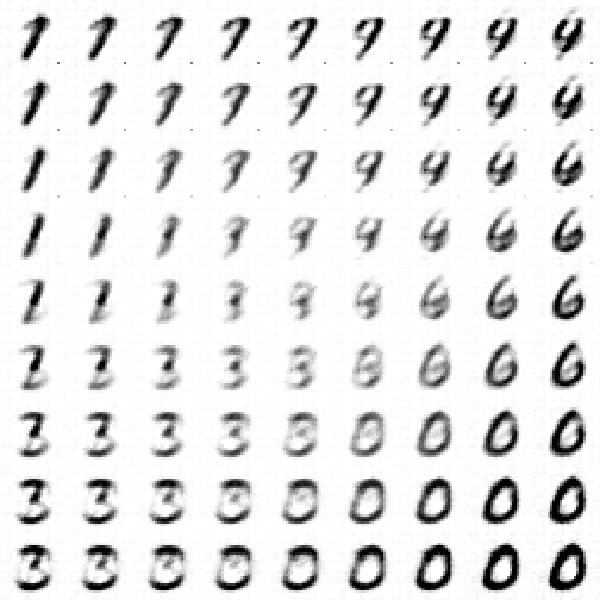

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
350,1.994381,1.793942,0.662673,0.022975,4.370573,1.030341,0.100929,0.18841,0.046041,0.096615,0.539869


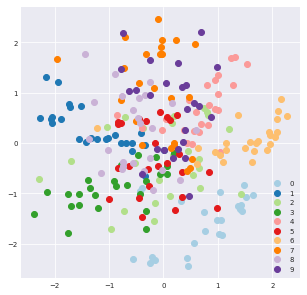

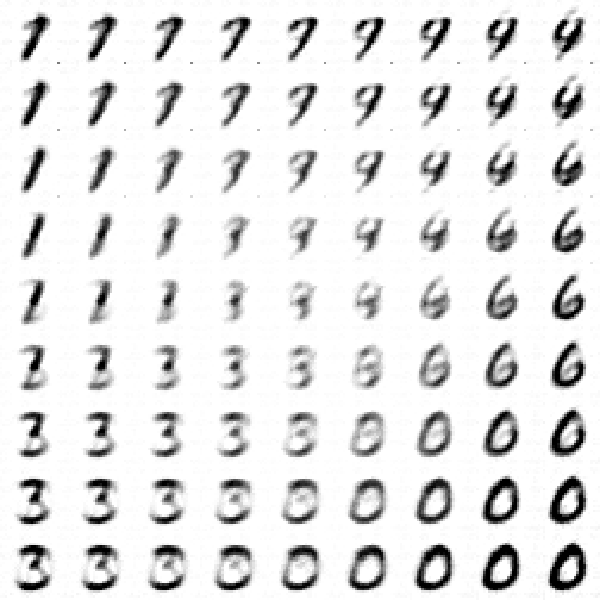

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
400,1.993205,1.729023,0.628047,0.051336,5.655826,1.005018,0.095958,0.185468,0.045905,0.096956,0.756731


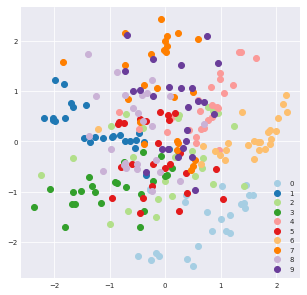

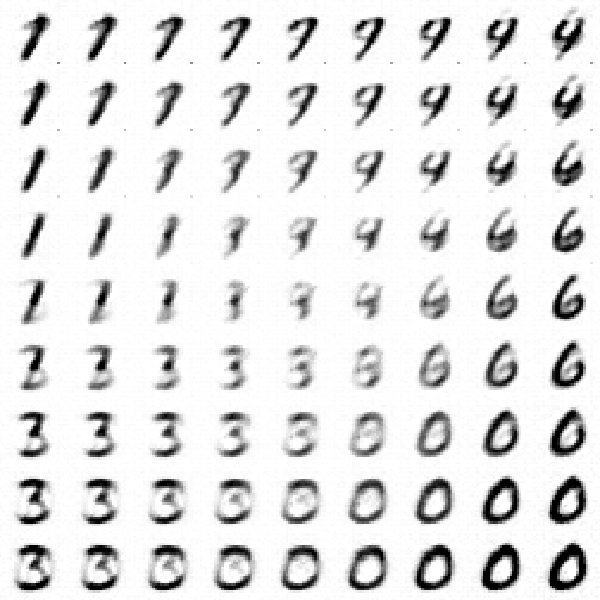

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
450,1.991504,1.636525,0.547027,0.044359,6.072417,0.997285,0.092213,0.186608,0.045938,0.097934,0.754005


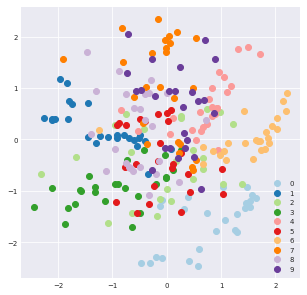

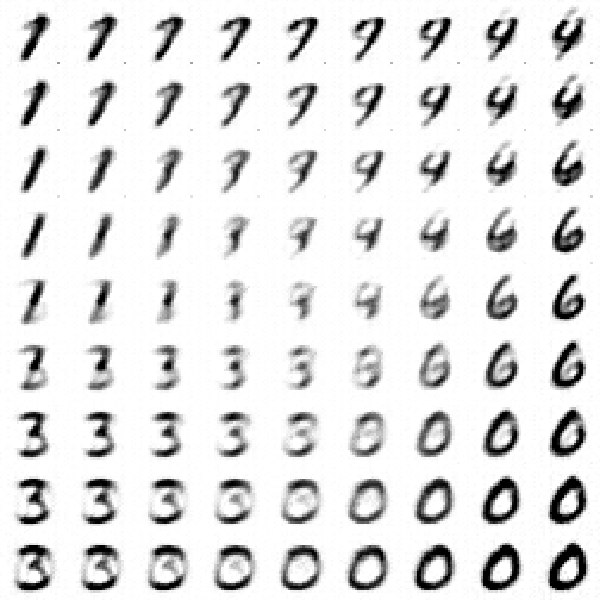

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
500,1.990327,1.49473,0.415767,0.039949,6.414092,0.990596,0.088367,0.184973,0.046079,0.097184,0.496602


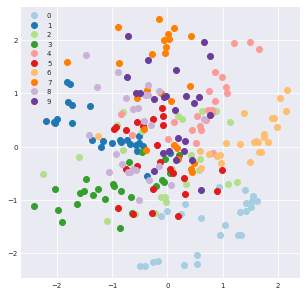

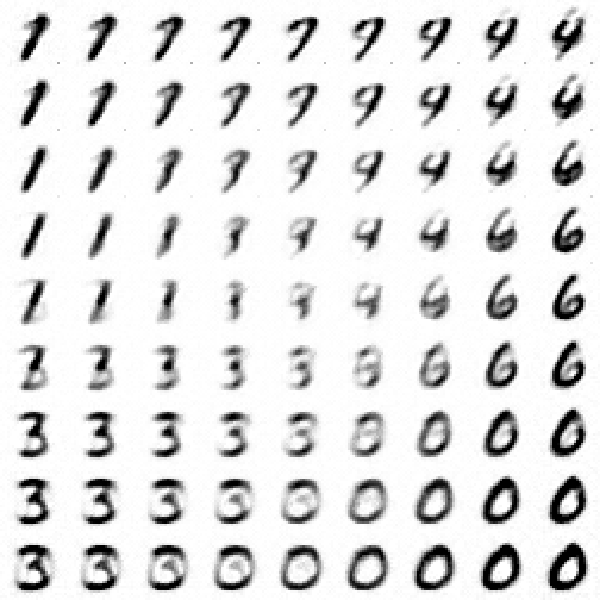

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
550,1.991017,1.660222,0.596991,0.067245,5.755286,0.977094,0.086137,0.194322,0.046078,0.097332,0.960642


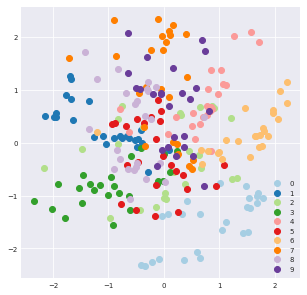

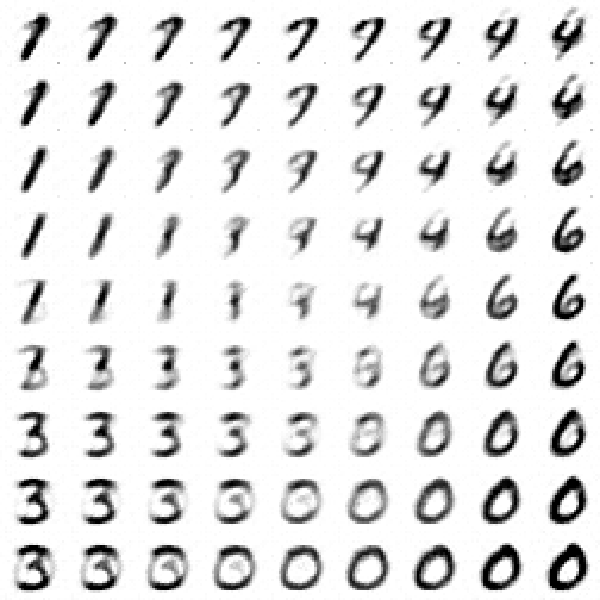

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
600,1.996425,1.517148,0.468005,0.074108,4.187562,0.965856,0.083287,0.180365,0.045863,0.096681,0.504484


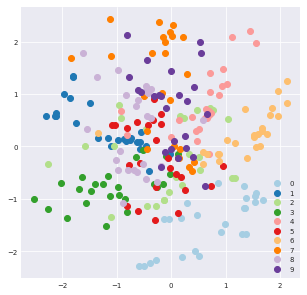

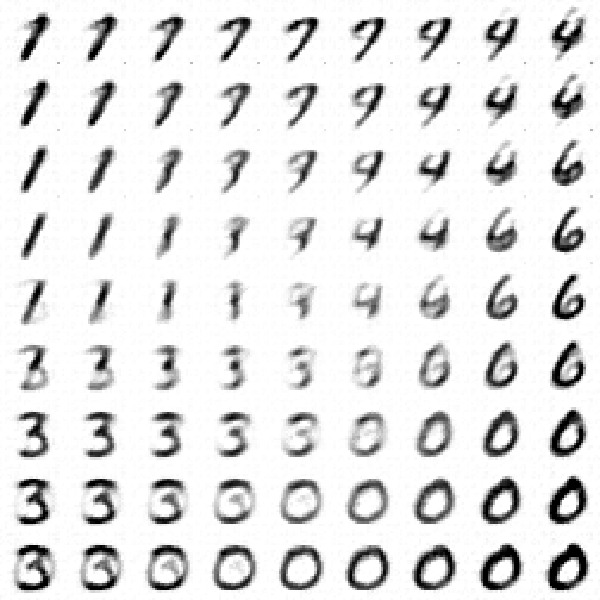

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
650,1.994811,1.538327,0.506262,0.081799,4.761996,0.951609,0.080457,0.18995,0.046083,0.096779,1.255114


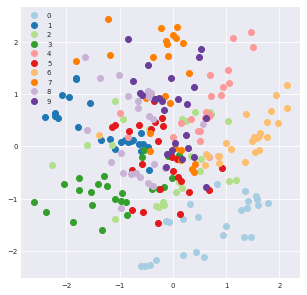

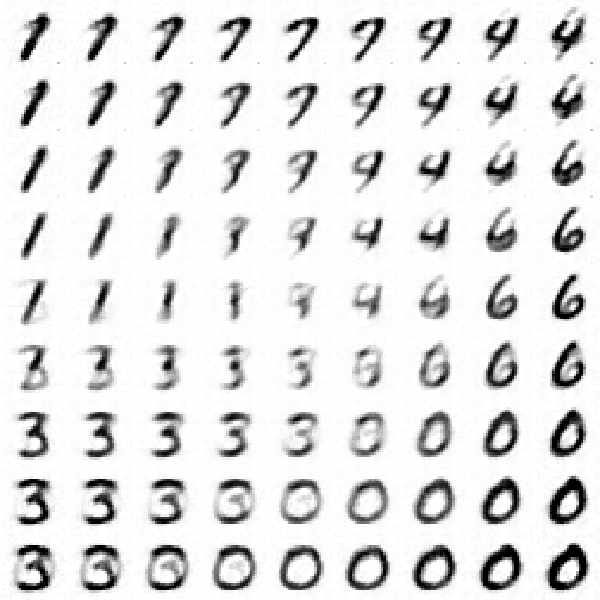

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
700,1.990655,1.797422,0.769127,0.043597,5.397816,0.949552,0.078743,0.183104,0.046075,0.097404,1.075488


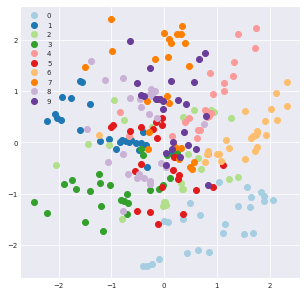

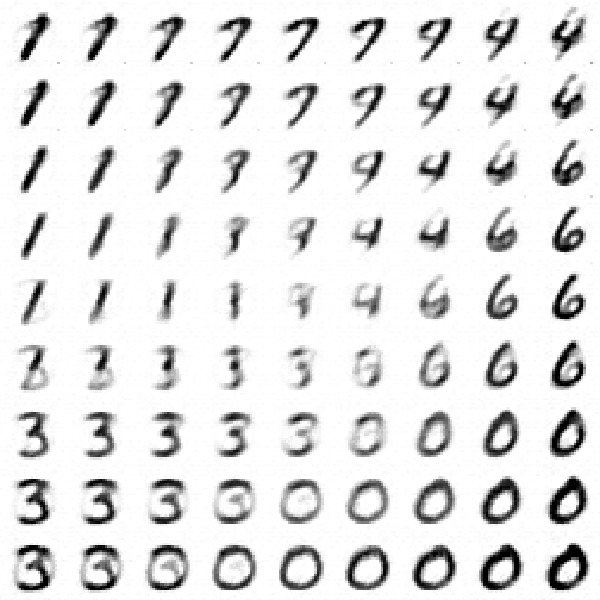

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
750,1.989396,1.736078,0.729054,0.031657,7.379885,0.930559,0.076465,0.193907,0.046116,0.097665,0.76119


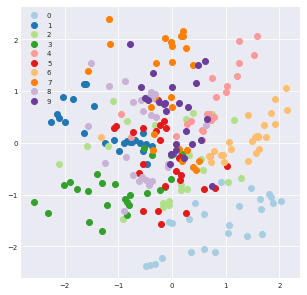

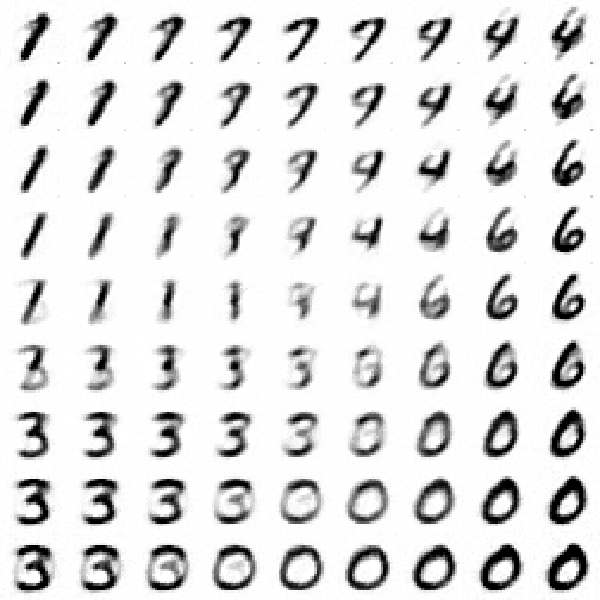

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
800,1.992926,1.739895,0.750314,0.034569,6.294722,0.914995,0.074586,0.220462,0.047835,0.097539,2.207596


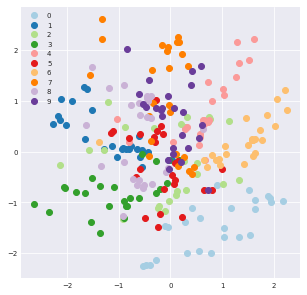

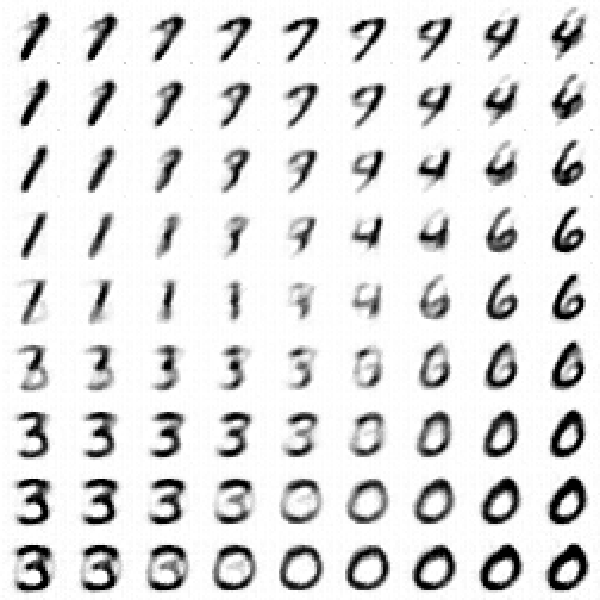

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
850,1.993497,1.734351,0.745299,0.047083,8.545983,0.915678,0.073373,0.197326,0.046129,0.097881,0.548068


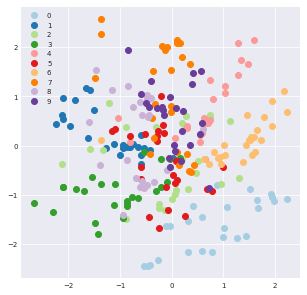

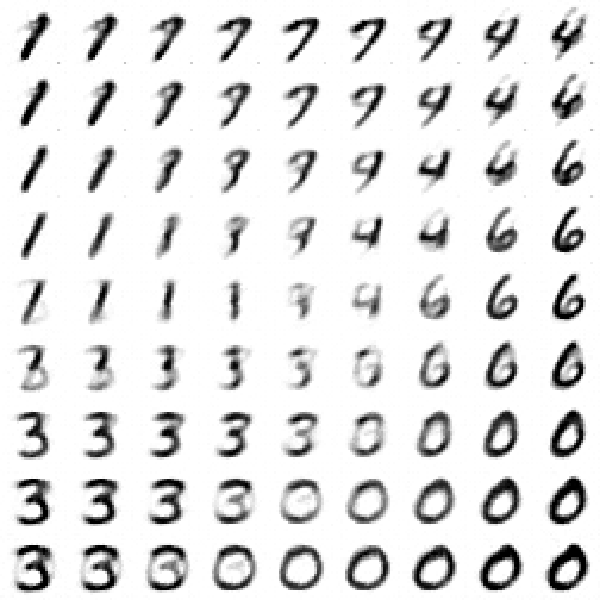

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
900,1.99082,1.674595,0.712886,0.043738,7.196963,0.890316,0.071393,0.195934,0.046551,0.097826,0.866629


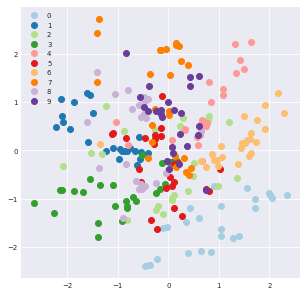

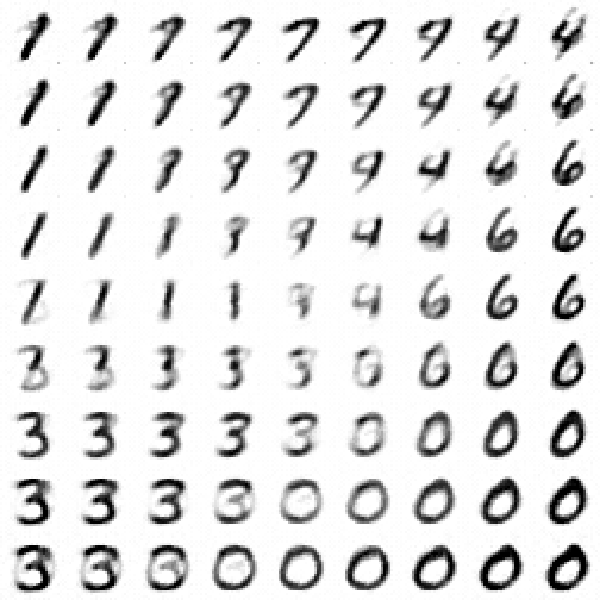

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
950,1.991819,1.52643,0.562997,0.027853,5.152399,0.893746,0.069687,0.185669,0.046105,0.097452,0.692962


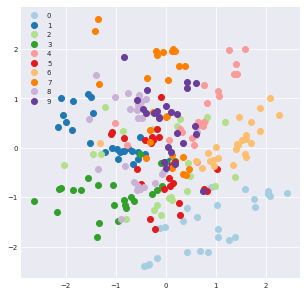

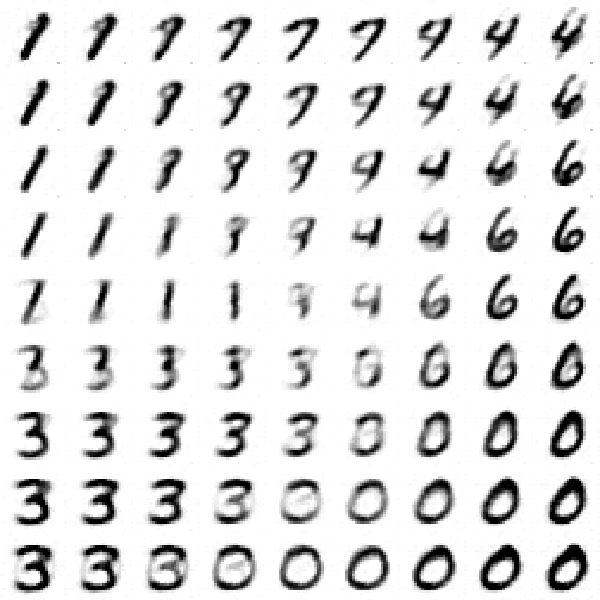

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1000,1.991385,1.454793,0.506834,0.052132,6.299394,0.879664,0.068296,0.185231,0.046112,0.097816,0.676465


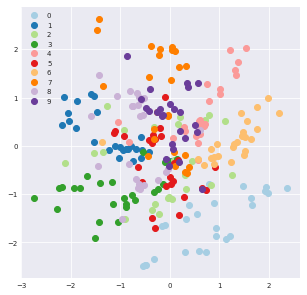

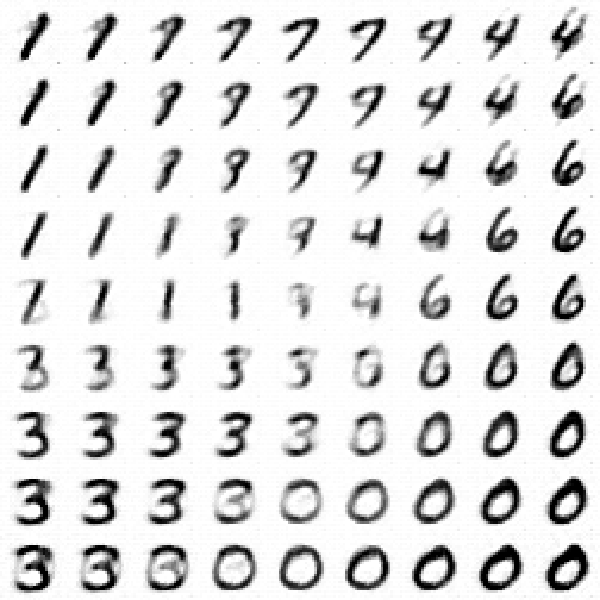

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1050,1.990901,1.607655,0.656316,0.032003,6.734187,0.884035,0.067305,0.202515,0.04631,0.097473,0.871123


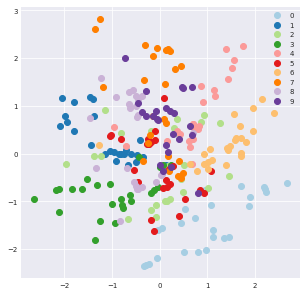

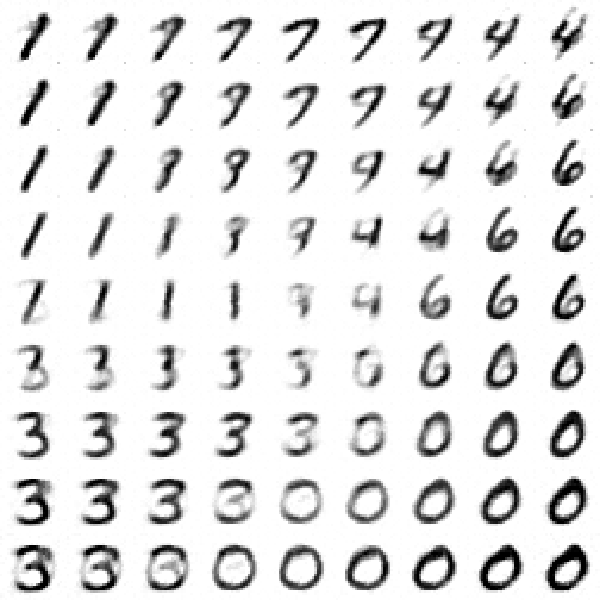

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1100,1.993155,1.65481,0.712696,0.038706,5.923766,0.87641,0.065704,0.193901,0.046187,0.097414,0.697684


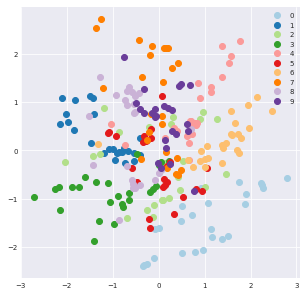

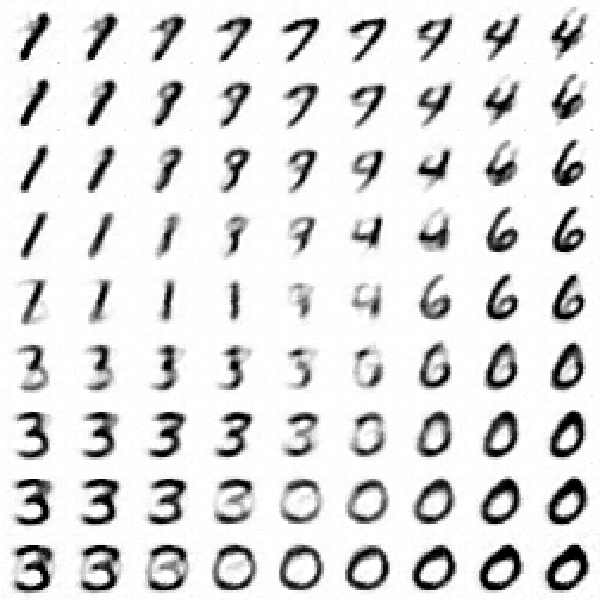

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1150,1.99282,1.468804,0.534949,0.036315,7.615978,0.869168,0.064687,0.187369,0.04607,0.097354,0.830173


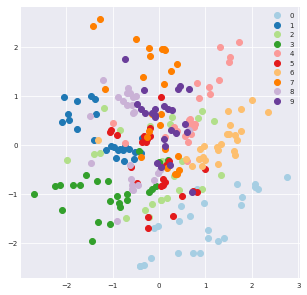

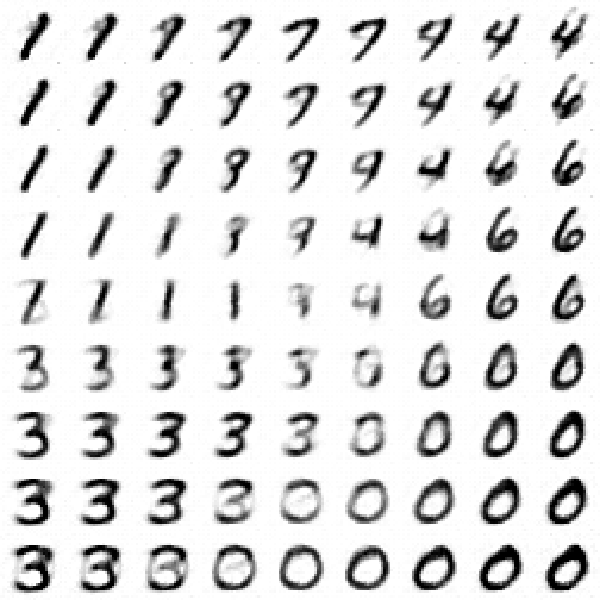

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1200,1.993353,1.649279,0.707315,0.025032,4.943964,0.878528,0.063436,0.186017,0.046128,0.096679,0.827026


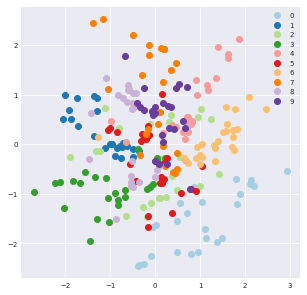

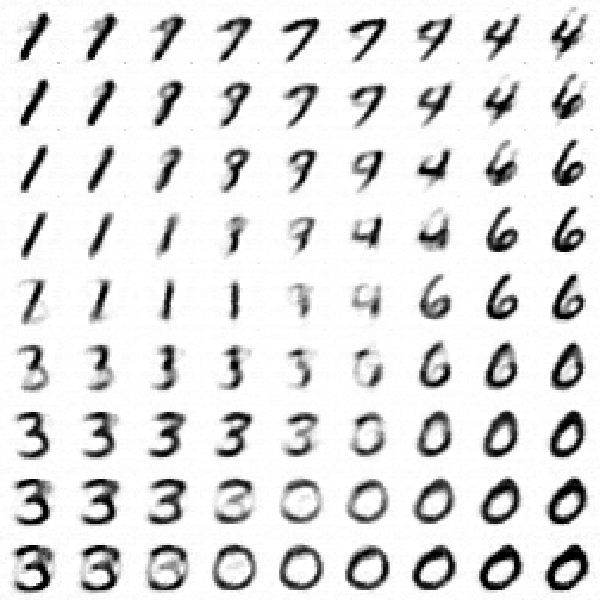

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1250,1.992215,1.648587,0.736988,0.024357,7.414061,0.849219,0.062379,0.201324,0.046762,0.098412,0.662074


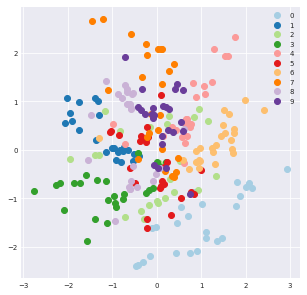

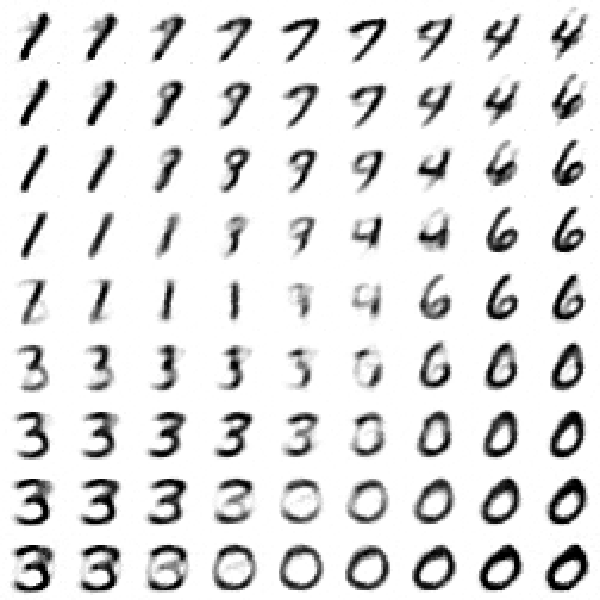

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1300,1.993474,1.669012,0.757216,0.057307,7.619717,0.850359,0.061437,0.193818,0.045988,0.097559,0.345254


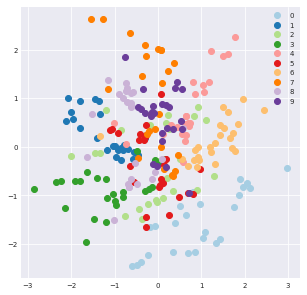

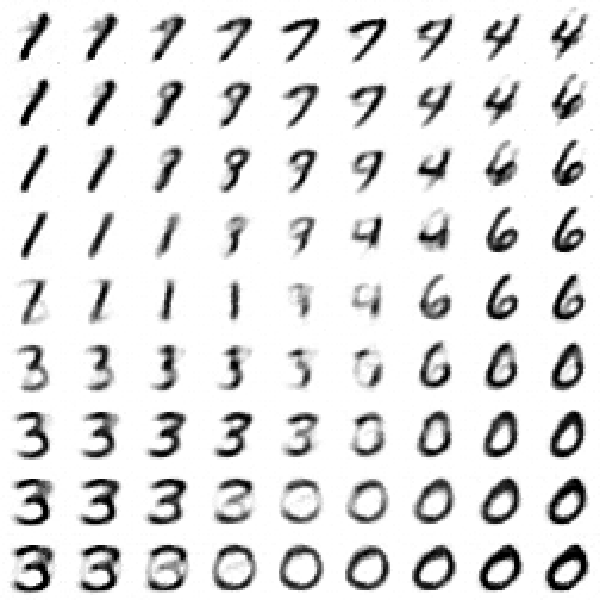

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1350,1.998135,1.621367,0.729834,0.060638,6.652372,0.831355,0.060178,0.208789,0.046111,0.097922,1.134637


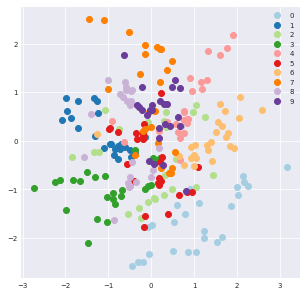

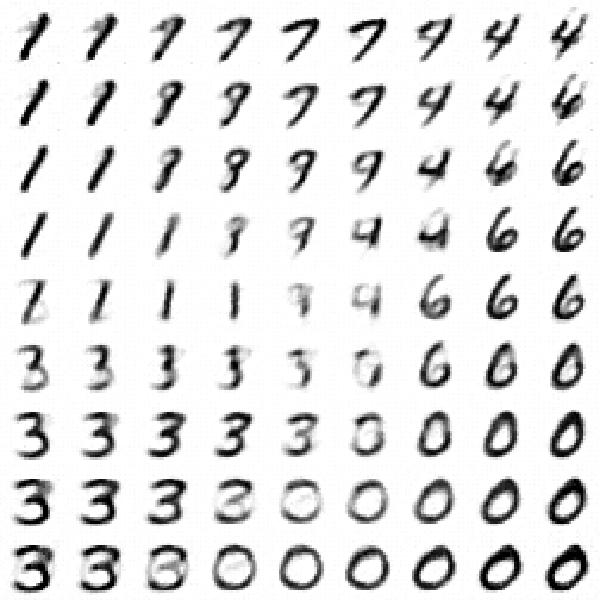

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1400,1.995736,1.549657,0.627541,0.054564,5.411935,0.862287,0.059828,0.187182,0.04612,0.097428,1.273003


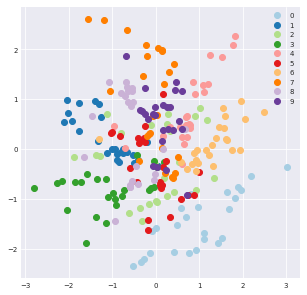

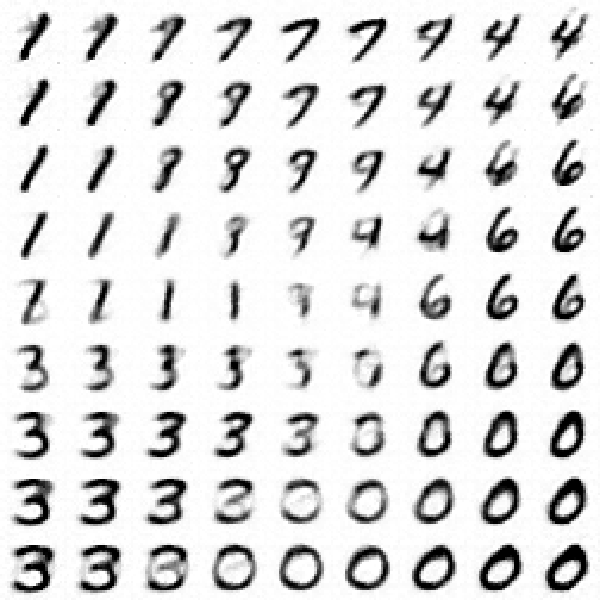

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1450,1.993038,1.632413,0.727966,0.035548,7.441136,0.845655,0.058791,0.186402,0.046371,0.097599,1.458078


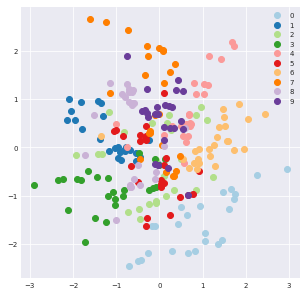

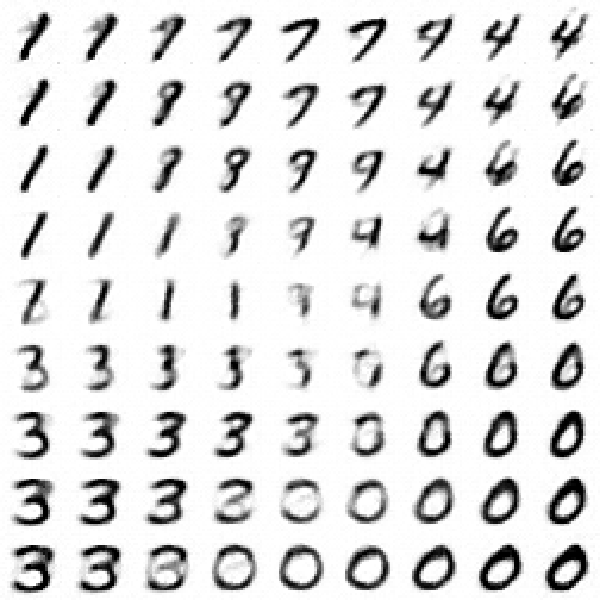

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1500,1.993058,1.650961,0.779469,0.033443,6.638395,0.813962,0.05753,0.182725,0.046327,0.097286,0.531354


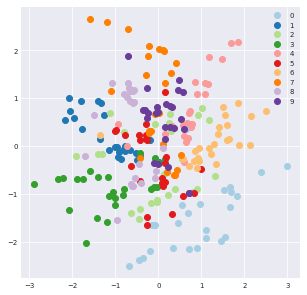

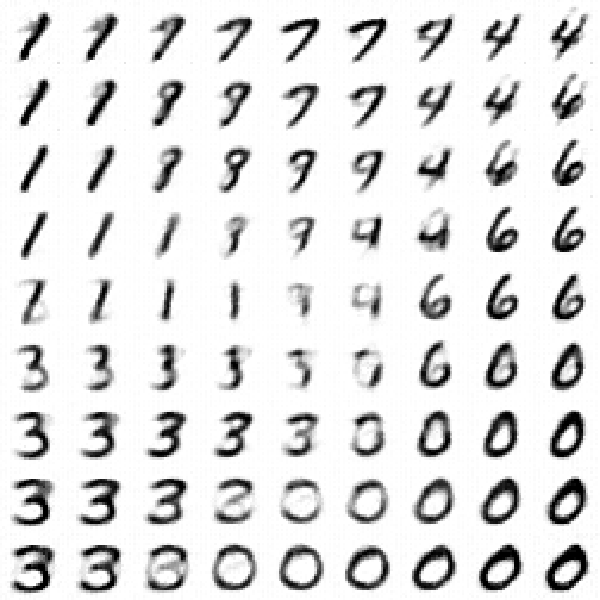

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1550,1.995813,1.539901,0.6556,0.055882,4.426301,0.82752,0.05678,0.18486,0.046055,0.097221,0.756622


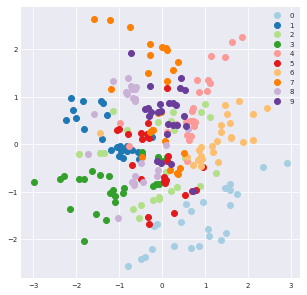

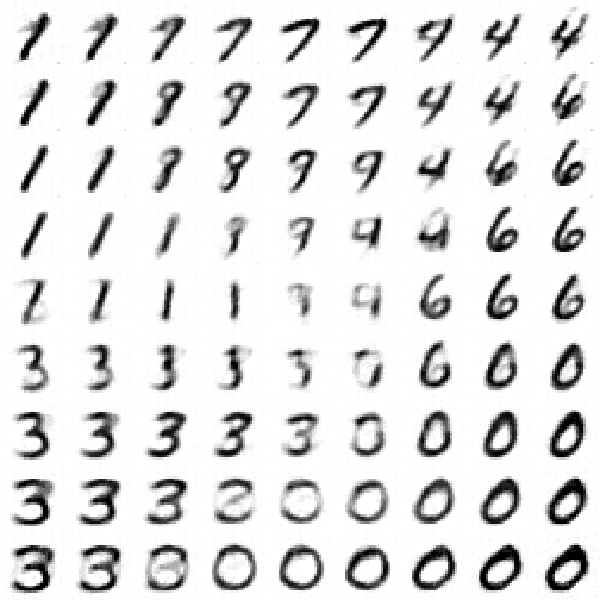

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1600,1.992907,1.476046,0.618656,0.042795,6.611357,0.801476,0.055913,0.182155,0.046177,0.097609,0.771225


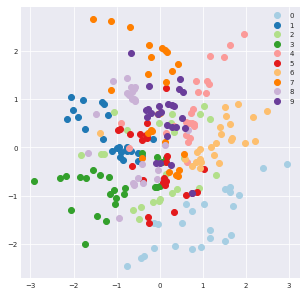

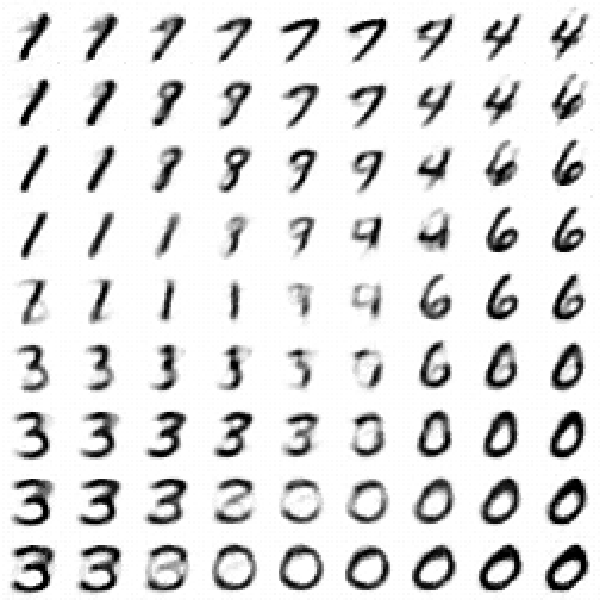

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1650,1.993361,1.530309,0.682068,0.025423,5.667999,0.793323,0.054918,0.194727,0.046237,0.097534,0.785514


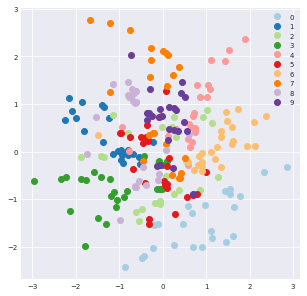

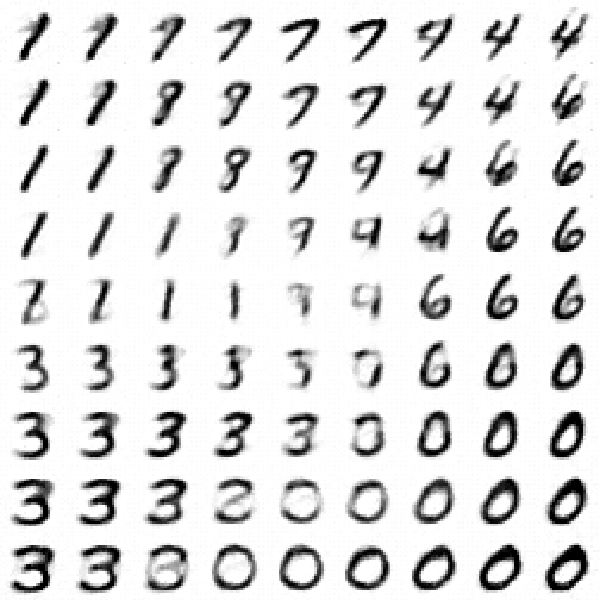

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1700,1.994506,1.665639,0.815738,0.032375,7.161676,0.795496,0.054405,0.179252,0.046049,0.097549,0.412213


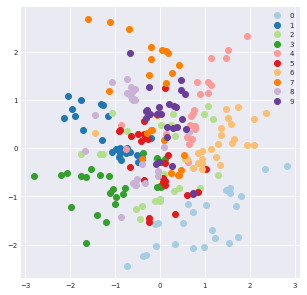

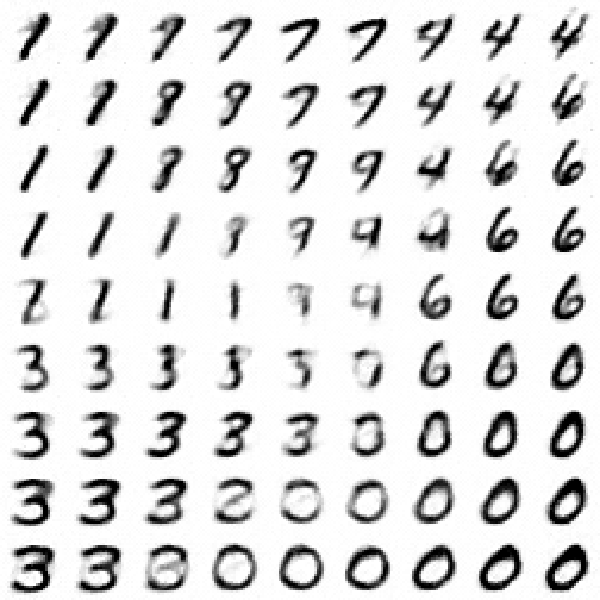

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1750,1.999644,1.706389,0.855523,0.059012,6.99736,0.797135,0.053731,0.217128,0.046144,0.097257,0.86876


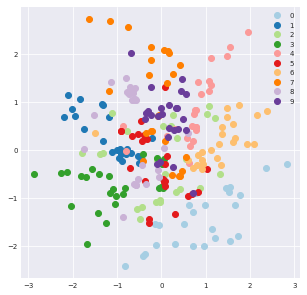

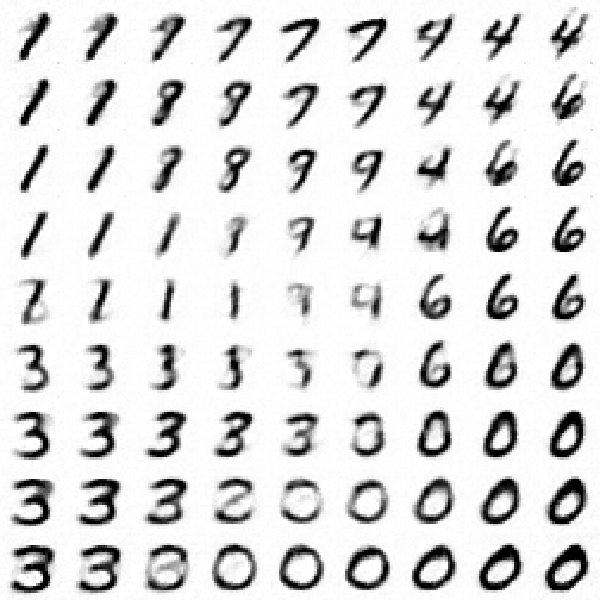

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1800,1.997205,1.502786,0.641272,0.04405,6.003846,0.808105,0.053409,0.197025,0.046215,0.097625,0.50107


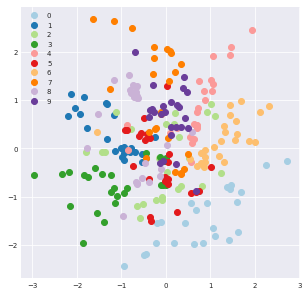

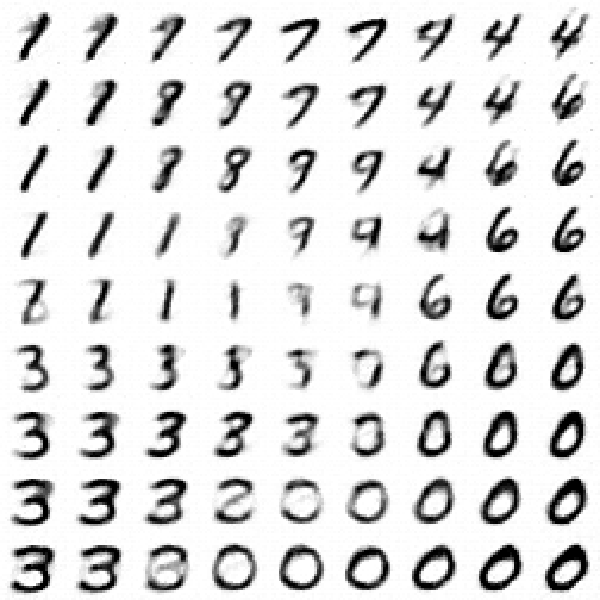

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1850,1.995136,1.456367,0.595036,0.042707,6.460837,0.808677,0.052654,0.190388,0.046119,0.098011,0.555566


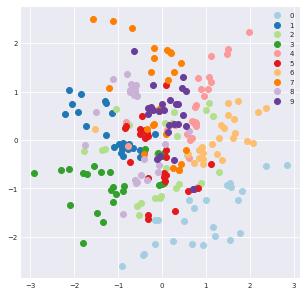

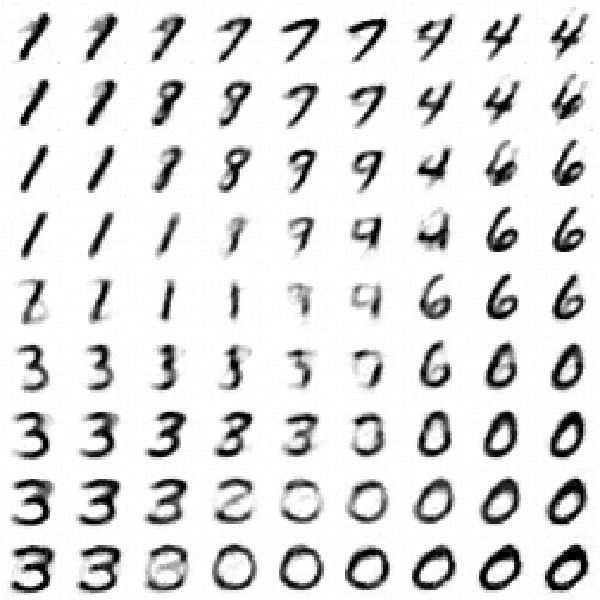

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1900,1.995418,1.672689,0.836549,0.027379,6.099979,0.784401,0.051738,0.197998,0.046077,0.09732,1.067559


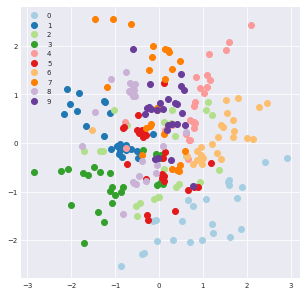

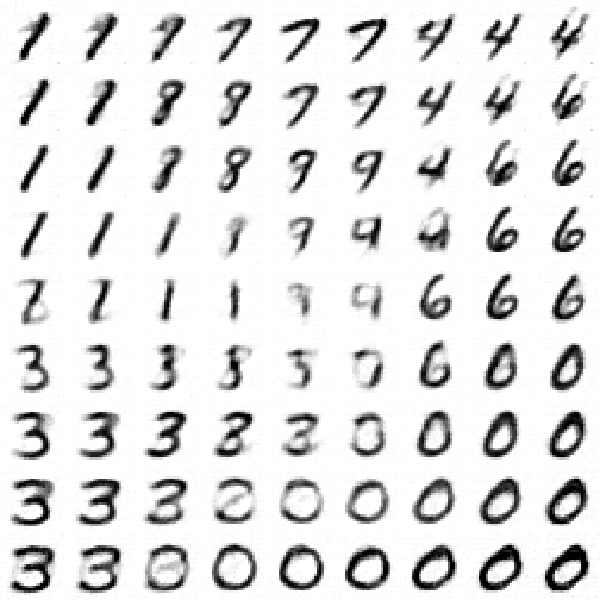

,d_loss,g_loss,g_loss_samples,grad_norm_D,grad_norm_g,in_loss,out_loss,runtime,runtime_d,runtime_g,sliced_rel
1950,1.997288,1.597965,0.73892,0.039079,6.204006,0.8072,0.051845,0.189803,0.045958,0.09742,1.45445


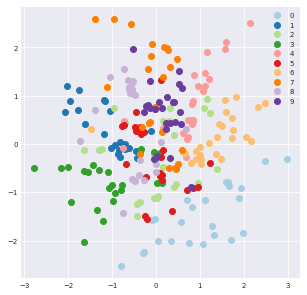

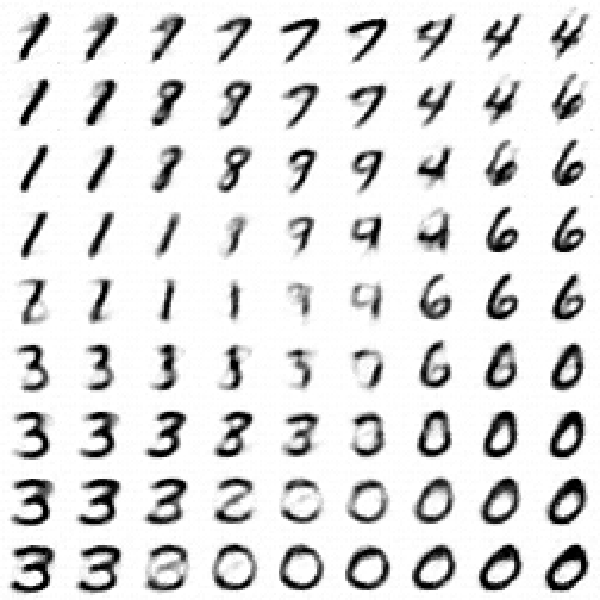

In [15]:
for i_epoch in range(2000):
    start_time = time.time()
    g_results = []
    d_results = []
    i_update = 0
    b_X = inputs
    b_X = b_X.cuda()
    g_result = train_gen_on_batch(b_X, only_clamp=False)
    g_results.append(g_result)
    d_result = train_critic_on_batch(b_X)
    d_results.append(d_result)
    i_update += 1
    result =  {**pd.DataFrame(g_results).mean(), **pd.DataFrame(d_results).mean()}
    relative_sliced = compute_sliced_dist_on_outputs()
    epoch_time = time.time() - start_time
    result['runtime'] = epoch_time
    result['sliced_rel'] = var_to_np(relative_sliced)[0]
    epochs_dataframe = epochs_dataframe.append(result, ignore_index=True)
    if i_epoch % 50 == 0:
        display(epochs_dataframe.iloc[-1:])
        i_class = 0
        mean = means_per_cluster[i_class]
        std = stds_per_cluster[i_class] * stds_per_cluster[i_class]
        outs_real = take_only_large_stds(feature_model(inputs), std,
                                         n_wanted_stds=2)
        fig = plt.figure(figsize=(5,5))
        palette = seaborn.color_palette('Paired', n_colors=10)
        outs_np = var_to_np(outs_real)
        for i_real_class in range(10):
            plt.plot(outs_np[y==i_real_class,0],
                     outs_np[y==i_real_class,1],
                     marker='o', ls='', color=palette[i_real_class], label=str(i_real_class))
        plt.legend()
        display(fig)
        plt.close(fig)
        i_std_1, i_std_2 = np.argsort(var_to_np(stds_per_cluster[0]))[::-1][:2]
        feature_a_values = th.linspace(float(mean[i_std_1].data - 2 * std[i_std_1].data),
                               float(mean[i_std_1].data + 2 * std[i_std_1].data), 9)
        feature_b_values = th.linspace(float(mean[i_std_2].data - 2 * std[i_std_2].data),
                               float(mean[i_std_2].data + 2 * std[i_std_2].data), 9)
        image_grid = np.zeros((len(feature_a_values), len(feature_b_values), 28,28))

        for i_f_a_val, f_a_val in enumerate(feature_a_values):
            for i_f_b_val, f_b_val in enumerate(feature_b_values):
                this_out = mean.clone()
                this_out.data[i_std_1] = f_a_val
                this_out.data[i_std_2] = f_b_val
                inverted = var_to_np(invert(feature_model, this_out.unsqueeze(0))[0]).squeeze()

                image_grid[i_f_a_val, i_f_b_val] = np.copy(inverted)
        im = create_bw_image(image_grid[::-1]).resize((6*100,6*100))
        display(im)

In [16]:
epochs_dataframe.columns

Index(['d_loss', 'g_loss', 'g_loss_samples', 'grad_norm_D', 'grad_norm_g',
       'in_loss', 'out_loss', 'runtime', 'runtime_d', 'runtime_g',
       'sliced_rel'],
      dtype='object')

(0, 2)

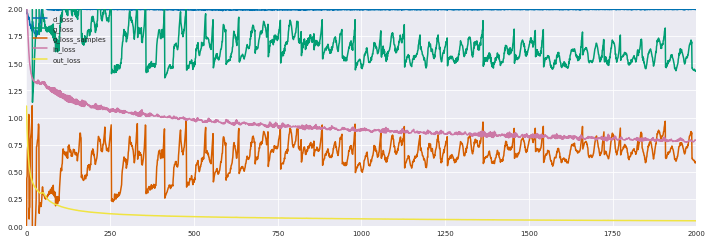

In [17]:
epochs_dataframe.loc[:,['d_loss', 'g_loss', 'g_loss_samples',
                        'in_loss', 'out_loss']].plot()
plt.ylim(0,2)